## Problem Statement:

**The objective of this project is to develop a time series forecasting model for predicting monthly sales of champagne using historical data. The dataset contains two columns: 'Months' and 'Sales.' The challenge is to create an accurate forecasting model that can provide reliable sales predictions for future months.**

**Importing Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**Importing Dataset** (dataset from kaggle)

In [2]:
# using parse_dates to convert the dtype into date and setting up ['Month'] as index column which is necessary in TSA

data = pd.read_csv('champagne.csv', parse_dates = ['Month'], index_col = 'Month')
data.head()  # checking first 5 values               



,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [3]:
data.shape       # lets see the number of rows and column

(105, 1)

In [4]:
type(data)

pandas.core.frame.DataFrame

* It is important to see the sales with time with graphical representation to understand its **Trend, seasonality, cyclic**

In [5]:
# we should check for null/ missing values

data.isnull().sum()

Sales    0
dtype: int64

In [6]:
# checking the description of dataset

data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


**In the descriptive Analysis we can get some useful insights**

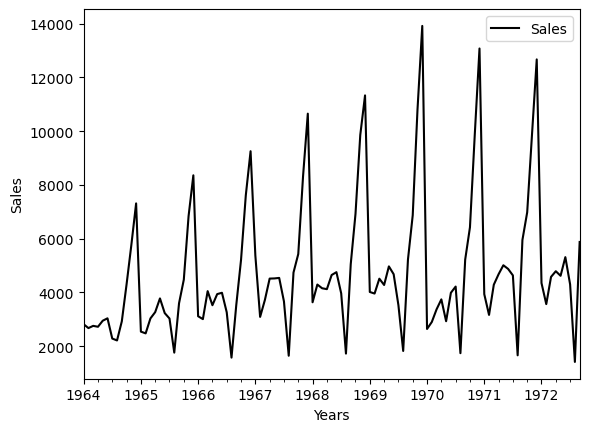

In [7]:
data.plot(c = 'black')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.show()         

* **if we see the above graph then we will able to find a trend that there is a time when sales are high and vice versa.**. 
* **That means we can see data is following seasonality.**.. 
* **For ARIMA first thing we do is identify if the data is stationary or non – stationary. if data is non-stationary we will try to make them stationary then we will process further.** .. 



* Let’s check that if the given dataset is stationary or not, For that we use adfuller.

In [8]:
from statsmodels.tsa.stattools import adfuller


* **Null Hypothesis (H0) = It is non-stationary**
* **Alternative Hypothesis (H1) = It is stationary** 

In [9]:
def adfuller_test(sales):
    result = adfuller(sales)
    
    print("ADF Test Statistic", result[0])
    print("p-value", result[1])
    print("#lags used", result[2])
    print("Number of Observations", result[3])
    
    
    if result[1] < 0.05:
        print("Reject Null Hypothesis : Data is Stationary")
    else:
        print("Fail to Reject Null Hypothesis : Data is Non-Stationary")
        
sales_data=data['Sales']
adfuller_test(sales_data)

ADF Test Statistic -1.8335930563276195
p-value 0.3639157716602467
#lags used 11
Number of Observations 93
Fail to Reject Null Hypothesis : Data is Non-Stationary


# we can also go ahead and check with Kpss test 
from statsmodels.tsa.stattools import kpss

def kpss_test(sales):
    results = kpss_test(sales)
    
    print("Test statistic", results[0])
    print("p_value", results[1])
    print("lags used", results[2])
    print("Number of observation", results[3])
    
    
    if results[1] < 0.05:
        print("Reject null hypothesis: Data is Stationary")
    else:
        print("Fail to Reject Null Hypothesis: Data is Non-Stationary")

sales = data['Sales']
kpss_test(sales)

* **it is clearly observed that it "Fail to Reject Null-Hypothesis" as the dataset is Non- Stationary.** .  
* **lets convert the dataset to stationary by Differencing process. First differnce and seasonal differnce** 

In [10]:
data['First difference'] = data['Sales'] - data['Sales'].shift(1)
data['Seasonal difference'] = data['Sales'] - data['Sales'].shift(12)
data.head(13)


,Sales,First difference,Seasonal difference
Month,,,
1964-01-01,2815,NaN,NaN
1964-02-01,2672,-143.0,NaN
1964-03-01,2755,83.0,NaN
1964-04-01,2721,-34.0,NaN
1964-05-01,2946,225.0,NaN
1964-06-01,3036,90.0,NaN
1964-07-01,2282,-754.0,NaN
1964-08-01,2212,-70.0,NaN
1964-09-01,2922,710.0,NaN


In [11]:
adfuller_test(data['First difference'].dropna())    # dropping the null values after differencing

ADF Test Statistic -7.189896448051006
p-value 2.51962044738698e-10
#lags used 11
Number of Observations 92
Reject Null Hypothesis : Data is Stationary


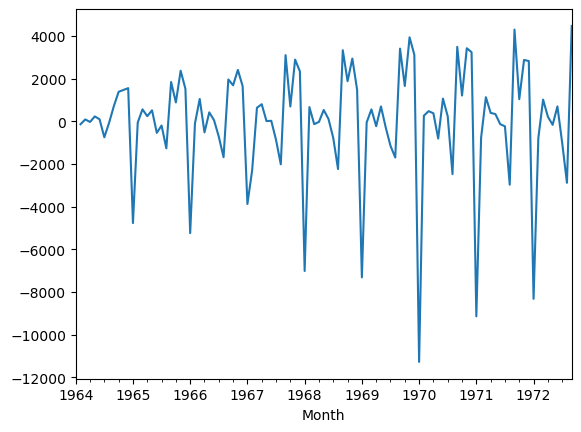

In [12]:
data['First difference'].plot()
plt.show()                  # we can see the grapgh is depecting seasonality 

In [13]:
adfuller_test(data['Seasonal difference'].dropna()) 

ADF Test Statistic -7.626619157213166
p-value 2.0605796968136632e-11
#lags used 0
Number of Observations 92
Reject Null Hypothesis : Data is Stationary


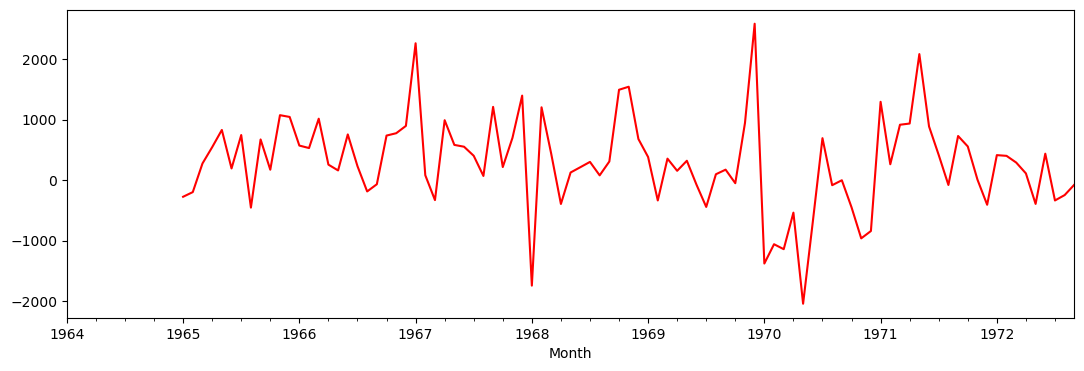

In [14]:
data['Seasonal difference'].plot(figsize = (13,4), c = 'red')
plt.show() # now the dataset seems to be statiionary  with no seasonality and trend in it .. good to go

since we have converted the dataset into **stationary** now we have to find the values of **(p,q,d)** for **ARIMA** model withe the help of **ACF** and **PCF** plots 

#####  since we have done only 1 differencing to convert into stationary out d value will be   (**d =1**)

In [15]:
from pandas.plotting import autocorrelation_plot

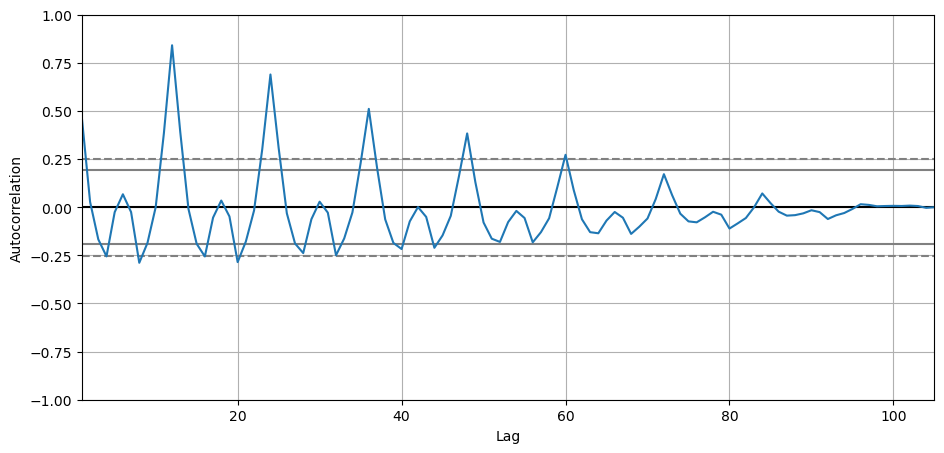

In [16]:
plt.figure(figsize=(11,5))
autocorrelation_plot(data['Sales'])
plt.show()

####  from the above auto correlation plot we can observe the value of q=1 or q=0

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

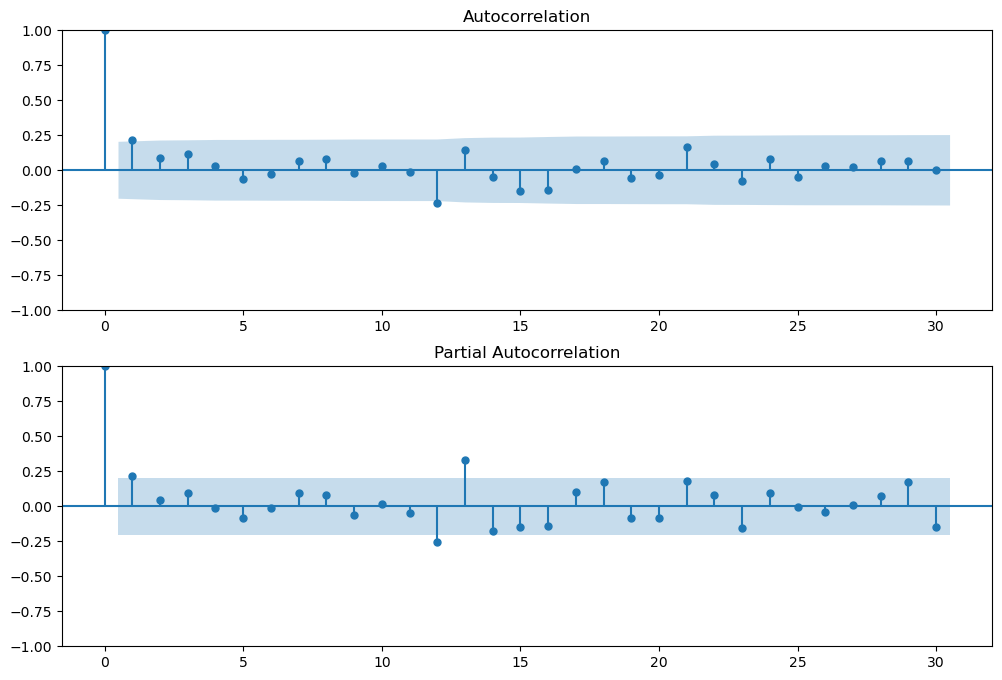

In [18]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Seasonal difference'].dropna(), lags = 30, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Seasonal difference'].dropna(), lags = 30, ax = ax2)
plt.show()

## so we get the vales of (p,q,d) = (1,1,1)

* **now we can implement ARIMA to forecast**

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
model = ARIMA(data['Sales'], order=(1,1,1))

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
model_fit = model.fit()

In [22]:
model_fit.params

ar.L1     4.544955e-01
ma.L1    -9.666349e-01
sigma2    5.225568e+06
dtype: float64

In [23]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Thu, 07 Sep 2023   AIC                           1911.627
Time:                        12:02:27   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
data.shape

(105, 3)

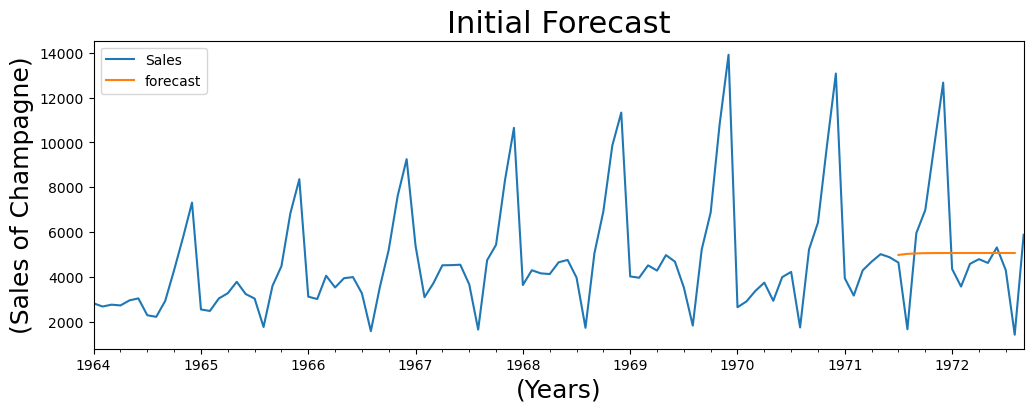

In [30]:
data['forecast'] = model_fit.predict(start = 90, end = 103, dynamic = True)
data[['Sales', 'forecast']].plot(figsize = (12,4))
plt.title("Initial Forecast", fontsize =22)
plt.xlabel('(Years)', fontsize = 18)
plt.ylabel('(Sales of Champagne)', fontsize = 18)
plt.show()

### importing SARIMAX to add seasonality and then forecast the sales 

In [31]:
model1 = sm.tsa.statespace.SARIMAX(data['Sales'], order = (1,1,1), seasonal_order = (1,1,1,12))
results_1 = model1.fit()

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


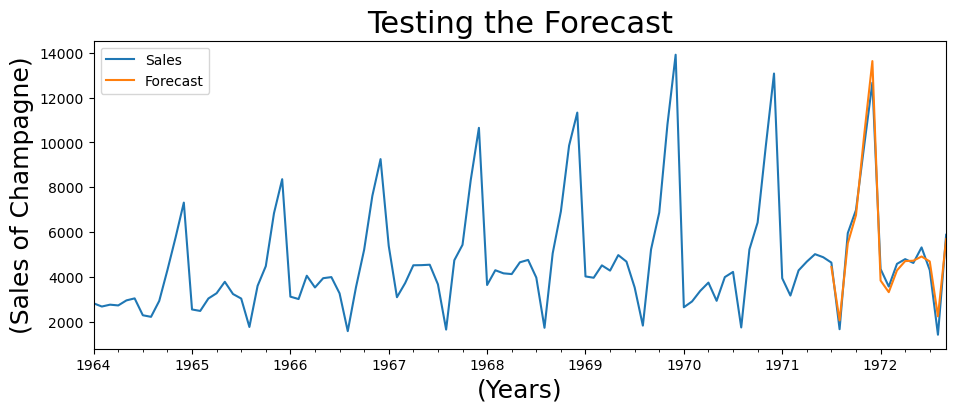

In [33]:
data['Forecast'] = results_1.predict(start = 90, end = 104, dynamic = True)
data[['Sales', 'Forecast']].plot(figsize = (11,4))
plt.title("Testing the Forecast", fontsize =22)
plt.xlabel('(Years)', fontsize = 18)
plt.ylabel('(Sales of Champagne)', fontsize = 18)
plt.show()


In [34]:
data[['Sales', 'Forecast']]

,Sales,Forecast
Month,,
1964-01-01,2815,NaN
1964-02-01,2672,NaN
1964-03-01,2755,NaN
1964-04-01,2721,NaN
1964-05-01,2946,NaN
...,...,...
1972-05-01,4618,4717.511635
1972-06-01,5312,4906.404400
1972-07-01,4298,4685.437156


### creating the future dates using pandas library and then concating it with the original dataset so that we can use the old SARIMAX model to predict the future sales based on the dates we create now

In [36]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

future_df=pd.concat([data,future_datest_df])



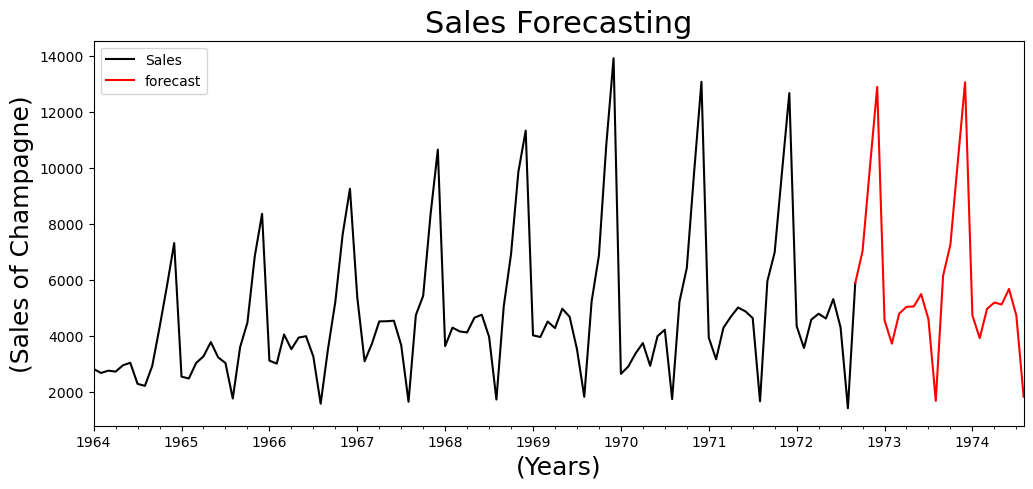

In [37]:
future_df['forecast'] = results_1.predict(start = 104, end = 128, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 5), color = ['black', 'red'])
plt.title("Sales Forecasting", fontsize =22)
plt.xlabel('(Years)', fontsize = 18)
plt.ylabel('(Sales of Champagne)', fontsize = 18)
plt.show()


In [38]:
# these are the forecasted values for next 24 months from the last date of the dataset provided
future_df['forecast'].tail(25)

1972-08-01             NaN
1972-09-01     5878.712035
1972-10-01     7024.263234
1972-11-01     9996.419744
1972-12-01    12892.152543
1973-01-01     4561.509744
1973-02-01     3718.817789
1973-03-01     4792.361196
1973-04-01     5034.610594
1973-05-01     5047.956777
1973-06-01     5488.573468
1973-07-01     4593.627754
1973-08-01     1676.138504
1973-09-01     6146.224252
1973-10-01     7262.512594
1973-11-01    10194.735835
1973-12-01    13057.412353
1974-01-01     4731.201210
1974-02-01     3915.317908
1974-03-01     4961.391475
1974-04-01     5189.453037
1974-05-01     5119.495249
1974-06-01     5675.242599
1974-07-01     4726.202412
1974-08-01     1823.475373
Name: forecast, dtype: float64